In [1]:
import numpy as np
from collections import deque,namedtuple
import time
import random
from itertools import count
import math

from tqdm import tqdm
import os
from PIL import Image
import cv2
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from sklearn.metrics import mean_squared_error as mse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import matplotlib
import matplotlib.pyplot as plt

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
device = torch.device('cuda')

In [4]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50_000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = MIN_REPLAY_MEMORY_SIZE // 10 # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MODEL_NAME = '2x256'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 20_000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
SHOW_PREVIEW = False
MOMENTS = 2

In [14]:
import numpy as np
from PIL import Image
import cv2

class snakeEnv():
   
    def __init__(self):
        self.actions = ['up','left','right','down','none']
        self.ACTION_SPACE_SIZE = len(self.actions)
        self.action_space = np.array([0,1,2,3,4])
        self.RES = 10
        self.SIZE = 1
        self.OBSERVATION_SPACE_VALUES = (self.RES//self.SIZE, self.RES//self.SIZE, MOMENTS) 
        self.states = []

        self.reset()

    def reset(self):
        self.length = 1
        self.dirs = {'W': True, 'S': True, 'A': True, 'D': True, }
        self.x, self.y = randrange(self.SIZE, self.RES - self.SIZE, self.SIZE), randrange(self.SIZE, self.RES - self.SIZE, self.SIZE)
        self.apple = randrange(self.SIZE, self.RES - self.SIZE, self.SIZE), randrange(self.SIZE, self.RES - self.SIZE, self.SIZE)
        self.snake = [(self.x, self.x)]
        self.dx, self.dy = 0, 0
        self.states = [self.getState()]*MOMENTS
        return np.float32(np.array(self.states[-MOMENTS:]).reshape(MOMENTS,self.RES,self.RES))
        
        
    def step(self, id_action):
        reward = 0
        terminated = False
        init_dist = np.linalg.norm(np.array(env.snake[-1]) -np.array(env.apple))
        
        
        if self.actions[id_action]=='up':
            if self.dirs['W']:
                self.dx, self.dy = 0, -1
                self.dirs = {'W': True, 'S': False, 'A': True, 'D': True, }
        elif self.actions[id_action]=='down':
            if self.dirs['S']:
                self.dx, self.dy = 0, 1
                self.dirs = {'W': False, 'S': True, 'A': True, 'D': True, }
        elif self.actions[id_action]=='left':
            if self.dirs['A']:
                self.dx, self.dy = -1, 0
                self.dirs = {'W': True, 'S': True, 'A': True, 'D': False, }
        elif self.actions[id_action]=='right':
            if self.dirs['D']:
                self.dx, self.dy = 1, 0
                self.dirs = {'W': True, 'S': True, 'A': False, 'D': True, }
        elif self.actions[id_action]=='none':
            reward += 0.1
                
        self.x += self.dx * self.SIZE
        self.y += self.dy * self.SIZE
        
        if self.length>1:
            self.snake.append((self.x, self.y))
            self.snake = self.snake[-self.length:]
        else:
            self.snake = [(self.x,self.y)]

        
        if self.snake[-1] == self.apple:
            reward += 20
            self.apple = randrange(self.SIZE, self.RES - self.SIZE, self.SIZE), randrange(self.SIZE, self.RES - self.SIZE, self.SIZE)
            self.length += 1

        if self.x < 0 or self.x > self.RES - self.SIZE or self.y < 0 or self.y > self.RES - self.SIZE or len(self.snake) != len(set(self.snake)):
            reward += -50
            terminated = True
                
        final_dist = np.linalg.norm(np.array(env.snake[-1]) -np.array(env.apple))
                
        observation = self.get_image()
        reward += (init_dist - final_dist)*2
        
        self.states.append(np.float32(observation))
        
        return np.array(self.states[-MOMENTS:]).reshape(MOMENTS, self.RES,self.RES), reward, terminated


    def getState(self):
        return self.get_image()
    
    def render(self, save = False, name = '1'):
        print()

        plt.imshow(self.states[-1].reshape((self.RES,self.RES)))
        if save:
#             img = Image.fromarray(self.states[-1].reshape((self.RES,self.RES,3))).resize((500,500))
#             img.save('games/'+name+'.jpg')
            plt.savefig('games/'+name+'.jpg')
        else:
            plt.show()
        
    def get_image(self):
        img = Image.new("RGB", (self.RES, self.RES))
        draw = ImageDraw.Draw(img)
        buf_size = 0 if self.SIZE == 1 else self.SIZE
        draw.rectangle([ (self.apple[0], self.apple[1]), (buf_size +  self.apple[0], buf_size +  self.apple[1])], fill = 'grey') 

        if len(self.snake)>1:
            for i, j in self.snake:
                draw.rectangle( [(i, j), (buf_size + i, buf_size + j)], fill = 'white')
        else:            
            for i, j in self.snake:
                draw.rectangle([ (self.snake[0][0], self.snake[0][1]), (buf_size +  self.snake[0][0], buf_size +  self.snake[0][1])], fill = 'white') 



        state_pic = np.array(img.convert("L"))
#         state_pic = np.array(img)


        return state_pic.reshape((self.RES,self.RES))

(10, 10)



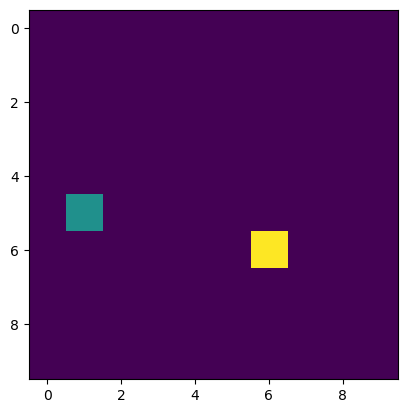

In [15]:
env = snakeEnv()
print(env.get_image().shape)
env.render(save=True)

In [9]:
class SnakeNet(nn.Module):

    def __init__(self):
        super(SnakeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 2, out_channels  = 128, kernel_size = 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels  = 256, kernel_size = 3, stride=1, padding=0)
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(256,32)  
        self.dense2 = nn.Linear(32, env.ACTION_SPACE_SIZE)
        

    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = self.dropout(x)
        
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = self.dropout(x)
        x = self.flatten(x)
        
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x

    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [10]:
policy_net = SnakeNet().to(device)
target_net = SnakeNet().to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [11]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space[random.randint(0,env.ACTION_SPACE_SIZE-1)]]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [12]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [13]:
num_episodes = 20000

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, done = env.step(action.item())
        episode_reward += reward
        reward = torch.tensor([reward], device=device)
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(episode_reward)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

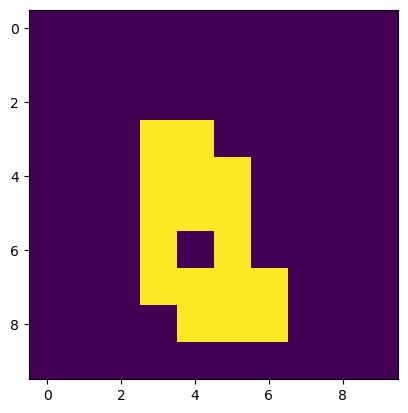

In [16]:
init = env.reset()
stp = False
i = 0
while not stp:
    env.render(save= True, name = str(i))    
    init = torch.tensor(init, dtype=torch.float32, device=device).unsqueeze(0)
    act = policy_net(init).max(1)[1].item()
    init, r, stp = env.step(act)
    i += 1
#     if i >5:
#         break

In [17]:
import imageio
with imageio.get_writer('movie.gif', mode='I') as writer:
    for i in range(max([ int(item.replace('.jpg','')) for item in os.listdir('games')])):

        image = imageio.imread('games/'+str(i)+'.jpg')
        writer.append_data(image)
        

C:\Users\ski1l\AppData\Local\Temp\ipykernel_808\1222942757.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('games/'+str(i)+'.jpg')


In [9]:
# for i in range(100):
#     optimizer.zero_grad()
    
#     y_pred = snakeNet.forward(batch)
#     loss_val = mse(y_pred, y_batch)
#     loss_val.backward()
    
#     optimizer.step()

In [19]:
# ep_rewards = [-200]

# if not os.path.isdir('models'):
#     os.makedirs('models')

            
# class DQNAgent:
#     def __init__(self):

#         self.model = SnakeNet()
#         self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
#         self.loss_function = nn.MSELoss()
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 0.001)


#     def update_replay_memory(self, transition):
#         self.replay_memory.append(transition)

#     def train(self, terminal_state, step):

#         if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
#             return
# #         print(123)
#         minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

#         current_states = np.array([transition[0] for transition in minibatch])/255
#         current_qs_list = self.model.forward(torch.from_numpy(current_states)).detach().numpy()
        
#         new_current_states = np.array([transition[3] for transition in minibatch])/255
#         future_qs_list = self.model.forward(torch.from_numpy(new_current_states)).detach().numpy()

#         X = []
#         y = []

#         for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
# #             print(2222, index)
#             if not done:
#                 max_future_q = np.max(future_qs_list[index])
#                 new_q = reward + DISCOUNT * max_future_q
#             else:
#                 new_q = reward

#             current_qs = current_qs_list[index]
#             current_qs[action] = new_q

#             X.append(current_state)
#             y.append(current_qs)

#         self.optimizer.zero_grad()
#         X = torch.tensor(np.array(X), requires_grad = True)
#         y_pred = self.model.forward(X)#.detach().numpy()
#         loss_val = self.loss_function(y_pred, torch.from_numpy(np.array(y) ))
#         loss_val.backward()      
#         self.optimizer.step()
        
            
#     def get_qs(self, state):
#         return self.model.forward(torch.from_numpy(np.array( [state])/255))[0].detach().numpy()

In [11]:
# agent = DQNAgent()


In [20]:
# MEAN_REWARD = -100
# reward_hist = []



# for episode in range(1, EPISODES + 1):
#     episode_reward = 0
#     step = 1

#     current_state = env.reset()
# #     print(episode)
#     done = False
#     while not done:

#         if np.random.random() > epsilon:
#             action = np.argmax(agent.get_qs(current_state.reshape(2,10,10)))
#         else:
#             action = np.random.randint(0, env.ACTION_SPACE_SIZE)

#         new_state, reward, done = env.step(action)

#         episode_reward += reward
#         agent.update_replay_memory((current_state, action, reward, new_state, done))
#         agent.train(done, step)

#         current_state = new_state
#         step += 1

#     reward_hist.append( episode_reward )
#     print(episode, episode_reward)
#     if episode % 50 ==0:    
#         MEAN_REWARD_PREV =  np.mean(reward_hist[-100:-50])
#         MEAN_REWARD =  np.mean(reward_hist[-50:])
# #         if MEAN_REWARD > MEAN_REWARD_PREV:
# #             agent.model.save('models/best.model')
#         print(episode, MEAN_REWARD)





#     MEAN_REWARD_PREV =  np.mean(reward_hist[-50:])

#     if epsilon > MIN_EPSILON:
#         epsilon *= EPSILON_DECAY
#         epsilon = max(MIN_EPSILON, epsilon)
